In [62]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import func4behav as fb
from scipy.stats import lognorm
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from scipy.stats import exponnorm
from pyddm import Model, Sample
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter, LossRobustBIC
from pyddm.functions import fit_adjust_model, display_model
from pyddm import Fittable, Fitted
import pyddm.plot

import imp
imp.reload(fb)

<module 'func4behav' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\behavior\\func4behav.py'>

In [63]:
behavior_compare, experiment = fb.create_allsubs_compare()
for subject_id in range (1,19):
    behavior_before, behavior_after = fb.load_behavior(subject_id)
    behavior_compare = fb.allsubs_compare(subject_id, behavior_before, behavior_after, behavior_compare, experiment, verbose=False)
display(behavior_compare)

behavior_compare = behavior_compare.loc[(behavior_compare['response'] == 1) & (behavior_compare['reaction time'] > 0.05) & (behavior_compare['type'] == 1)]
rt_sham = behavior_compare.loc[behavior_compare['Real stimulation'] == 0]
rt_real = behavior_compare.loc[behavior_compare['Real stimulation'] == 1]
# rt_sham = fb.remove_outlier(rt_sham)
# rt_real = fb.remove_outlier(rt_real)
rt_sham_before = rt_sham.loc[rt_sham['session'] == 'before', 'reaction time'].values
rt_sham_after = rt_sham.loc[rt_sham['session'] == 'after', 'reaction time'].values
rt_real_before = rt_real.loc[rt_real['session'] == 'before', 'reaction time'].values
rt_real_after = rt_real.loc[rt_real['session'] == 'after', 'reaction time'].values

,subject id,trial,Real stimulation,session,type,cue,valid,ICS,stim,response,reaction time
0,1,1,1,before,2,1,1,0.5,1,1,0.27437
1,1,2,1,before,2,-1,1,1.0,-1,1,0.21226
2,1,3,1,before,1,-1,-1,0.5,1,1,0.40884
3,1,4,1,before,1,-1,-1,0.5,1,1,0.22220
4,1,5,1,before,1,1,1,1.0,1,1,0.19879
...,...,...,...,...,...,...,...,...,...,...,...
4315,18,116,1,after,1,-1,1,1.0,-1,1,0.24539
4316,18,117,1,after,1,1,1,1.0,1,1,0.21152
4317,18,118,1,after,2,1,-1,1.0,-1,1,0.32075
4318,18,119,1,after,2,-1,-1,0.5,1,1,0.46414


In [64]:
# Function to fit a shifted log-normal distribution
def shifted_lognorm(x, s, scale, loc):
    return lognorm.pdf(x, s, loc=loc, scale=scale)

def fit_and_plot_shift_lognorm(data, title):
    # Estimate initial parameters
    shape, loc, scale = lognorm.fit(data, floc=0)
    params, _ = curve_fit(shifted_lognorm, np.sort(data), lognorm.pdf(np.sort(data), shape, loc=loc, scale=scale), p0=[shape, scale, loc])

    # Generate x values
    x = np.linspace(min(data), max(data), 1000)

    # Get the fitted distribution values
    fitted_values = shifted_lognorm(x, *params)

    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, x, fitted_values)

    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)

    # Plot the histogram of the data
    plt.hist(data, bins=50, density=True, alpha=0.6, color='blue')

    # Plot the fitted shifted log-normal distribution
    plt.plot(x, fitted_values, 'r--', label='Fitted shifted log-normal distribution')

    plt.title(f'{title} (MSE: {mse:.5f})')
    plt.xlabel('Reaction Time (s)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()
    return mse


def fit_and_plot_exgaussian(data, title):
    # Fit Ex-Gaussian distribution
    K, loc, scale = exponnorm.fit(data)

    # Generate x values
    x = np.linspace(min(data), max(data), 1000)

    # Compute the Ex-Gaussian PDF
    fitted_values = exponnorm.pdf(x, K, loc, scale)

    # Compute histogram
    hist, bin_edges = np.histogram(data, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Interpolate fitted values at the bin centers
    fitted_values_interpolated = np.interp(bin_centers, x, fitted_values)

    # Compute the mean squared error
    mse = mean_squared_error(hist, fitted_values_interpolated)

    # Plot the histogram of the data
    plt.hist(data, bins=50, density=True, alpha=0.6, color='blue')

    # Plot the fitted Ex-Gaussian distribution
    plt.plot(x, fitted_values, 'r--', label='Fitted Ex-Gaussian distribution')

    plt.title(f'{title} (MSE: {mse:.5f})')
    plt.xlabel('Reaction Time (s)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    return mse

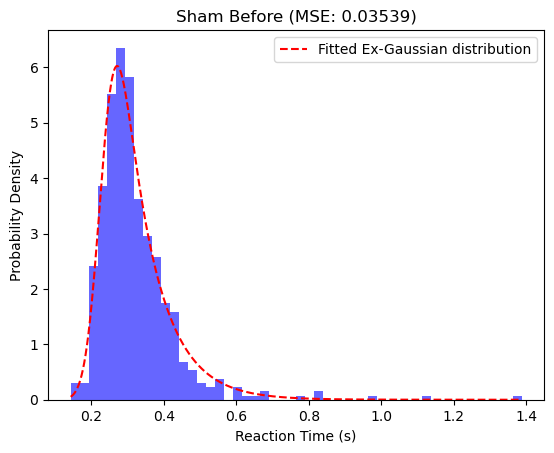

0.03538608380341665

In [65]:
fit_and_plot_exgaussian(rt_sham_before, 'Sham Before')


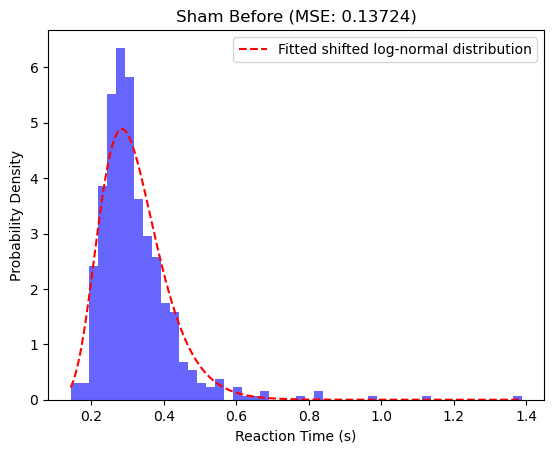

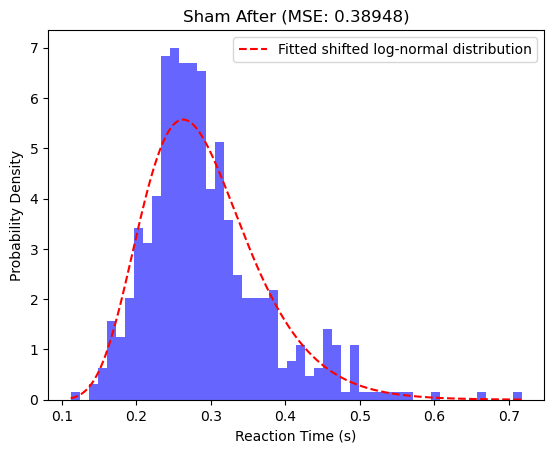

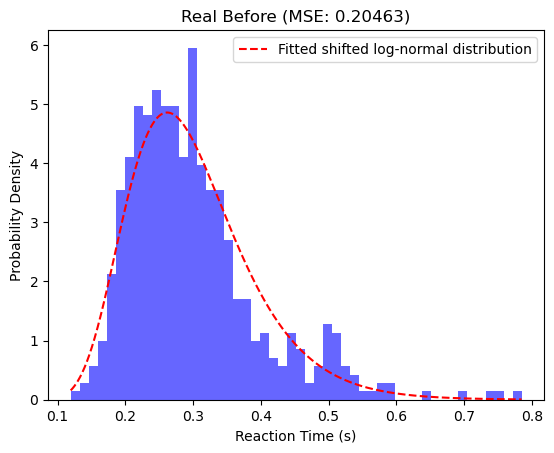

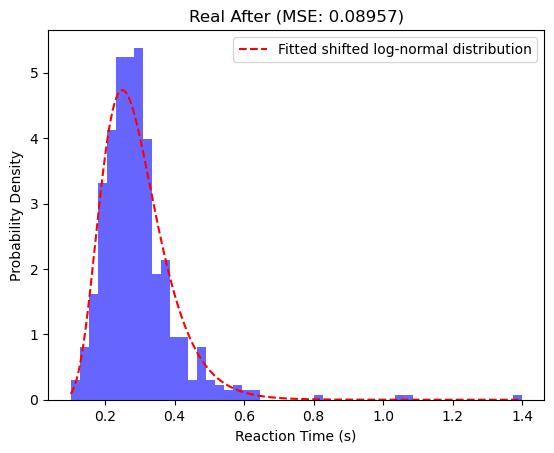

0.08957438553324548

In [66]:
# Fit and plot each of your datasets
fit_and_plot_shift_lognorm(rt_sham_before, 'Sham Before')
fit_and_plot_shift_lognorm(rt_sham_after, 'Sham After')
fit_and_plot_shift_lognorm(rt_real_before, 'Real Before')
fit_and_plot_shift_lognorm(rt_real_after, 'Real After')

In [67]:
rt_sham_before.shape[0]

531

In [71]:
rt = rt_real_before.copy()
corr = np.ones(rt.shape[0])
M = np.column_stack((rt, corr))

data = Sample.from_numpy_array(M, [])

model_fit = Model(name='My data (fitted)',
                  drift=DriftConstant(drift=Fittable(minval=-1, maxval=20)),
                  noise=NoiseConstant(noise=Fittable(minval=0.01, maxval=10)),
                  bound=BoundConstant(B=Fittable(minval=0.01, maxval=10)),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1.5)),
                  dx=.001, dt=.01, T_dur=2)
fit_adjust_model(data, model_fit,
                 fitting_method="differential_evolution",
                 lossfunction=LossRobustBIC, verbose=False)

# Get the fitted parameters
params = model_fit.parameters()

prediction = model_fit.solve()

# Compute the MSE
mse = ((rt - prediction)**2).mean()

print("MSE:", mse)

Info: Params [13.27906565  2.65223138  3.05217996  0.07035679] gave -1086.4620189329517


TypeError: unsupported operand type(s) for -: 'float' and 'Solution'

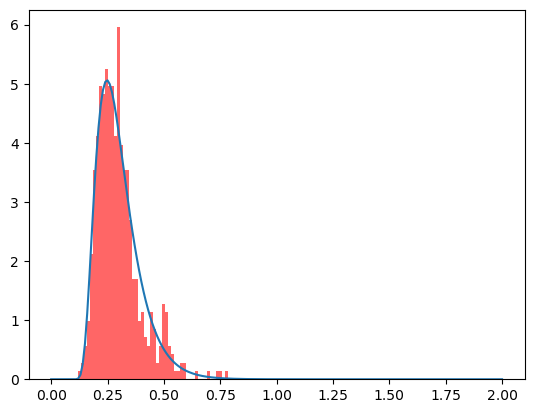

In [75]:
plt.plot(prediction.t_domain, prediction.pdf("correct"))
plt.hist(data, bins=50, density=True, alpha=0.6, color='red')
plt.show()

In [ ]:
pyddm.plot.model_gui(model=model_fit, sample=data)

KeyboardInterrupt: 